In [1]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData

# Load encoded data from CSV files
encoded_drugbank_id_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_drugbank_id.csv')
encoded_name_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_name.csv')
encoded_state_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_state.csv')
encoded_groups_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_groups.csv')
encoded_categories_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_categories.csv')
encoded_atc_codes_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_atc_codes.csv')
encoded_targets_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_targets.csv')
encoded_interactions_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_interactions.csv')
encoded_molecular_formula_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_molecular_formula.csv')
encoded_doping_df = pd.read_csv('Heterogeneous KG\encoders_small\encoded_doping.csv')

# Convert DataFrames to tensors
encoded_drugbank_id_tensor_1 = torch.tensor(encoded_drugbank_id_df.values, dtype=torch.float32)
encoded_name_tensor_1 = torch.tensor(encoded_name_df.values, dtype=torch.float32)
encoded_state_tensor_1 = torch.tensor(encoded_state_df.values, dtype=torch.float32)
encoded_groups_tensor_1 = torch.tensor(encoded_groups_df.values, dtype=torch.float32)
encoded_categories_tensor_1 = torch.tensor(encoded_categories_df.values, dtype=torch.float32)
encoded_atc_codes_tensor_1 = torch.tensor(encoded_atc_codes_df.values, dtype=torch.float32)
encoded_targets_tensor_1 = torch.tensor(encoded_targets_df.values, dtype=torch.float32)
encoded_interactions_tensor_1 = torch.tensor(encoded_interactions_df.values, dtype=torch.float32)
encoded_molecular_formula_tensor_1 = torch.tensor(encoded_molecular_formula_df.values, dtype=torch.float32)
encoded_doping_tensor_1 = torch.tensor(encoded_doping_df.values, dtype=torch.float32)

# Initialize HeteroData
data_small = HeteroData()

# Add Drug node features
data_small['drug'].x = torch.cat([
    encoded_drugbank_id_tensor_1,
    encoded_name_tensor_1,
    encoded_state_tensor_1,
    encoded_groups_tensor_1,
    encoded_molecular_formula_tensor_1
], dim=1)

data_small['drug_category'].x = torch.eye(len(encoded_categories_df.columns), dtype=torch.float32)
data_small['atc_code'].x = torch.eye(len(encoded_atc_codes_df.columns), dtype=torch.float32)
data_small['target'].x = torch.eye(len(encoded_targets_df.columns), dtype=torch.float32)
data_small['doping'].x = torch.eye(len(encoded_doping_df['Doping'].unique()), dtype=torch.float32)

source_nodes = []
target_nodes = []
for drug_idx, row in encoded_categories_df.iterrows():
    for category_idx in range(len(row)):
        if row[category_idx] == 1:
            source_nodes.append(drug_idx)
            target_nodes.append(category_idx)
data_small['drug', 'isInCategory', 'drug_category'].edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

source_nodes = []
target_nodes = []
for drug_idx, row in encoded_atc_codes_df.iterrows():
    for atc_code_idx in range(len(row)):
        if row[atc_code_idx] == 1:
            source_nodes.append(drug_idx)
            target_nodes.append(atc_code_idx)
data_small['drug', 'isClassifiedAs', 'atc_code'].edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

source_nodes = []
target_nodes = []
for drug_idx, row in encoded_targets_df.iterrows():
    for target_idx in range(len(row)):
        if row[target_idx] == 1:
            source_nodes.append(drug_idx)
            target_nodes.append(target_idx)
data_small['drug', 'targets', 'target'].edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

source_nodes = []
target_nodes = []
for drug_idx, doping in enumerate(encoded_doping_df['Doping']):
    source_nodes.append(drug_idx)
    target_nodes.append(doping)
data_small['drug', 'isDoping', 'doping'].edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

source_nodes = []
target_nodes = []
for drug_idx, row in encoded_interactions_df.iterrows():
    for target_idx in range(len(row)):
        if row[target_idx] == 1:
            source_nodes.append(drug_idx)
            target_nodes.append(target_idx)
data_small['drug', 'interactsWith', 'drug'].edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print(data_small)


c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


HeteroData(
  drug={ x=[338, 467] },
  drug_category={ x=[1095, 1095] },
  atc_code={ x=[974, 974] },
  target={ x=[249, 249] },
  doping={ x=[2, 2] },
  (drug, isInCategory, drug_category)={ edge_index=[2, 8347] },
  (drug, isClassifiedAs, atc_code)={ edge_index=[2, 2229] },
  (drug, targets, target)={ edge_index=[2, 338] },
  (drug, isDoping, doping)={ edge_index=[2, 338] },
  (drug, interactsWith, drug)={ edge_index=[2, 41415] }
)


In [3]:
def analyze_hetero_data(data):
    total_nodes = 0
    total_edges = 0
    total_features = 0
    unique_nodes = set()
    num_node_types = len(data.node_types)
    num_edge_types = len(data.edge_types)
    
    for node_type in data.node_types:
        num_nodes = data[node_type].num_nodes
        total_nodes += num_nodes
        total_features += data[node_type].x.size(1) if 'x' in data[node_type] else 0
        unique_nodes.update(range(num_nodes))
    
    for edge_type in data.edge_types:
        total_edges += data[edge_type].edge_index.size(1)
    
    average_nodes = total_nodes / num_node_types if num_node_types > 0 else 0
    average_edges = total_edges / num_edge_types if num_edge_types > 0 else 0
    
    return {
        'total_nodes': total_nodes,
        'total_edges': total_edges,
        'total_features': total_features,
        'unique_nodes': len(unique_nodes),
        'average_nodes': average_nodes,
        'average_edges': average_edges,
    }

# Analyze the HeteroData
analysis_result = analyze_hetero_data(data_small)
print(analysis_result)

{'total_nodes': 2658, 'total_edges': 52667, 'total_features': 2787, 'unique_nodes': 1095, 'average_nodes': 531.6, 'average_edges': 10533.4}


In [9]:
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGNN, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isClassifiedAs', 'atc_code'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'targets', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isDoping', 'doping'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interactsWith', 'drug'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['drug'])

labels_tensor = torch.tensor(encoded_doping_df.values, dtype=torch.long)

data_small['drug'].y = labels_tensor

train_indices, test_indices = train_test_split(range(len(labels_tensor)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

data_small['drug'].train_mask = torch.zeros(len(labels_tensor), dtype=torch.bool)
data_small['drug'].train_mask[train_indices] = True

data_small['drug'].val_mask = torch.zeros(len(labels_tensor), dtype=torch.bool)
data_small['drug'].val_mask[val_indices] = True

data_small['drug'].test_mask = torch.zeros(len(labels_tensor), dtype=torch.bool)
data_small['drug'].test_mask[test_indices] = True


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(hidden_channels=64, out_channels=2).to(device)
data_small = data_small.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_small.x_dict, data_small.edge_index_dict)
    loss = criterion(out[data_small['drug'].train_mask], data_small['drug'].y[data_small['drug'].train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data_small.x_dict, data_small.edge_index_dict)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data_small['drug'].y[mask]
        
        precision = precision_score(data_small['drug'].y[mask].cpu(), pred[mask].cpu(), average='macro', zero_division=0)
        recall = recall_score(data_small['drug'].y[mask].cpu(), pred[mask].cpu(), average='macro', zero_division=0)
        f1 = f1_score(data_small['drug'].y[mask].cpu(), pred[mask].cpu(), average='macro', zero_division=0)
        
        return int(correct.sum()) / int(mask.sum()), precision, recall, f1

# To accumulate metrics across epochs
train_precisions = []
train_recalls = []
train_f1s = []

val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(1, 101):
    loss = train()
    train_acc, train_precision, train_recall, train_f1 = test(data_small['drug'].train_mask)
    val_acc, val_precision, val_recall, val_f1 = test(data_small['drug'].val_mask)
    test_acc = test(data_small['drug'].test_mask)
    
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')

# Calculate the average metrics over all epochs
avg_train_precision = sum(train_precisions) / len(train_precisions)
avg_train_recall = sum(train_recalls) / len(train_recalls)
avg_train_f1 = sum(train_f1s) / len(train_f1s)

avg_val_precision = sum(val_precisions) / len(val_precisions)
avg_val_recall = sum(val_recalls) / len(val_recalls)
avg_val_f1 = sum(val_f1s) / len(val_f1s)

print(f'Average Train Precision: {avg_train_precision:.4f}, Average Train Recall: {avg_train_recall:.4f}, Average Train F1: {avg_train_f1:.4f}')
print(f'Average Val Precision: {avg_val_precision:.4f}, Average Val Recall: {avg_val_recall:.4f}, Average Val F1: {avg_val_f1:.4f}')

# Test the model
test_acc, test_precision, test_recall, test_f1 = test(data_small['drug'].test_mask)
print(f'Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}')


In [41]:
# Convert to homogeneous data
homogeneous_data = data_small.to_homogeneous()

print(homogeneous_data)

Data(edge_index=[2, 52667], x=[2658, 1095], node_type=[2658], edge_type=[52667])


In [43]:
from torch_geometric.nn import SAGEConv

class GraphSAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.0):
        super(GraphSAGENet, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[self.num_layers - 1](x, edge_index)
        return x

# Define the model
model = GraphSAGENet(
    in_channels=homogeneous_data.num_node_features,
    hidden_channels=64,
    out_channels=32,
    num_layers=3,
    dropout=0.5
)


In [30]:
doping_edges = data_small['drug', 'isDoping', 'doping'].edge_index
doping_labels = torch.zeros(data_small['drug'].num_nodes, dtype=torch.long)

# Assign doping labels based on the connections
for i in range(doping_edges.size(1)):
    drug_idx = doping_edges[0, i]
    doping_node_idx = doping_edges[1, i]
    doping_labels[drug_idx] = doping_node_idx

# Print labels to verify
print(doping_labels)


tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(homogeneous_data.num_features, 16)
        self.conv2 = GCNConv(16, 1)  # Output a single value per node for binary classification

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.view(-1)  # Flatten the output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
homogeneous_data = homogeneous_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(homogeneous_data.x, homogeneous_data.edge_index)
    loss = F.binary_cross_entropy_with_logits(out[homogeneous_data.train_mask], homogeneous_data.y[homogeneous_data.train_mask].float())
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Set up the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',  # Changed to raw
    ),
)

node_index = 10  # Adjust the node index to the node you want to explain
explanation = explainer(homogeneous_data.x, homogeneous_data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

# Visualize the feature importance and the subgraph
feature_importance_path = 'feature_importance_2.png'
explanation.visualize_feature_importance(feature_importance_path, top_k=10)
print(f"Feature importance plot has been saved to '{feature_importance_path}'")

subgraph_path = 'subgraph_2.pdf'
explanation.visualize_graph(subgraph_path)
print(f"Subgraph visualization plot has been saved to '{subgraph_path}'")


In [28]:
################################################################################################################
############################# DGL GnnExplainer on Heterogeneous Graph ##########################################
############################## Randomly (for now) assigns target binary values #########################################
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer

homogeneous_data.y = torch.randint(0, 2, (homogeneous_data.num_nodes,))
homogeneous_data.train_mask = torch.rand(homogeneous_data.num_nodes) < 0.8  # 80% training data
homogeneous_data.test_mask = ~homogeneous_data.train_mask  

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(homogeneous_data.num_features, 16)
        self.conv2 = GCNConv(16, 1)  # Output a single value per node

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.view(-1)  # Flatten the output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
homogeneous_data = homogeneous_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(homogeneous_data.x, homogeneous_data.edge_index)
    loss = F.binary_cross_entropy_with_logits(out[homogeneous_data.train_mask], homogeneous_data.y[homogeneous_data.train_mask].float())
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Set up the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',  # Changed to raw
    ),
)

node_index = 10  
explanation = explainer(homogeneous_data.x, homogeneous_data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

feature_importance_path = 'feature_importance.png'
explanation.visualize_feature_importance(feature_importance_path, top_k=10)
print(f"Feature importance plot has been saved to '{feature_importance_path}'")

subgraph_path = 'subgraph.pdf'
explanation.visualize_graph(subgraph_path)
print(f"Subgraph visualization plot has been saved to '{subgraph_path}'")


Epoch 1, Loss: 4.021499156951904
Epoch 2, Loss: 1.8996111154556274
Epoch 3, Loss: 2.359252452850342
Epoch 4, Loss: 2.2768759727478027
Epoch 5, Loss: 1.6378166675567627
Epoch 6, Loss: 1.0048009157180786
Epoch 7, Loss: 1.1392329931259155
Epoch 8, Loss: 1.4427670240402222
Epoch 9, Loss: 1.303633689880371
Epoch 10, Loss: 1.1058425903320312
Epoch 11, Loss: 0.9544612169265747
Epoch 12, Loss: 1.0106987953186035
Epoch 13, Loss: 1.344774842262268
Epoch 14, Loss: 1.0694342851638794
Epoch 15, Loss: 0.8905770778656006
Epoch 16, Loss: 0.8253978490829468
Epoch 17, Loss: 0.9889668822288513
Epoch 18, Loss: 0.8250640034675598
Epoch 19, Loss: 0.8119599223136902
Epoch 20, Loss: 0.7490168809890747
Epoch 21, Loss: 0.7632656693458557
Epoch 22, Loss: 0.836004376411438
Epoch 23, Loss: 0.7602275013923645
Epoch 24, Loss: 0.73019939661026
Epoch 25, Loss: 0.7256032824516296
Epoch 26, Loss: 0.7364026308059692
Epoch 27, Loss: 0.7295311689376831
Epoch 28, Loss: 0.7316322922706604
Epoch 29, Loss: 0.7164143323898315
E

In [56]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomNodeSplit

# Add doping labels to the drug nodes
data_small['drug'].y = torch.tensor(encoded_doping_df['Doping'].values, dtype=torch.long)

# Perform a node-level random split
transform = RandomNodeSplit(split='random', num_splits=1)
data_small = transform(data_small)

# Verify masks
print(data_small['drug'].train_mask.sum(), data_small['drug'].val_mask.sum(), data_small['drug'].test_mask.sum())


tensor(40) tensor(298) tensor(0)


In [58]:
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

class HeteroGNN1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGNN1, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isClassifiedAs', 'atc_code'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'targets', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isDoping', 'doping'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interactsWith', 'drug'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['drug'])

model1 = HeteroGNN1(hidden_channels=64, out_channels=2)


In [60]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomNodeSplit
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

# Load encoded data from CSV files and convert to tensors (omitted for brevity)
# Initialize HeteroData and add nodes and edges (omitted for brevity)

# Add doping labels to the drug nodes
data_small['drug'].y = torch.tensor(encoded_doping_df['Doping'].values, dtype=torch.long)

# Perform a node-level random split with ensured allocation
transform = RandomNodeSplit(split='random', num_train_per_class=20, num_val=200, num_test=100)
data_small = transform(data_small)

# Verify masks
print('Train mask sum:', data_small['drug'].train_mask.sum().item())
print('Val mask sum:', data_small['drug'].val_mask.sum().item())
print('Test mask sum:', data_small['drug'].test_mask.sum().item())

class HeteroGNN1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGNN1, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isClassifiedAs', 'atc_code'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'targets', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isDoping', 'doping'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interactsWith', 'drug'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['drug'])

model1 = HeteroGNN1(hidden_channels=64, out_channels=2)
# Define optimizer and loss function
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model1.train()
    optimizer.zero_grad()
    out = model1(data_small.x_dict, data_small.edge_index_dict)
    loss = criterion(out[data_small['drug'].train_mask], data_small['drug'].y[data_small['drug'].train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model1.eval()
    with torch.no_grad():
        out = model1(data_small.x_dict, data_small.edge_index_dict)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data_small['drug'].y[mask]
        if int(mask.sum()) == 0:  # Check to avoid division by zero
            return float('nan')
        return int(correct.sum()) / int(mask.sum())

for epoch in range(1, 101):
    loss = train()
    train_acc = test(data_small['drug'].train_mask)
    val_acc = test(data_small['drug'].val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

test_acc = test(data_small['drug'].test_mask)
print(f'Test Acc: {test_acc:.4f}')


Train mask sum: 40
Val mask sum: 200
Test mask sum: 98
Epoch: 001, Loss: 2.6936, Train Acc: 0.5000, Val Acc: 0.3500
Epoch: 002, Loss: 7.4080, Train Acc: 0.5000, Val Acc: 0.3500
Epoch: 003, Loss: 4.1280, Train Acc: 0.5750, Val Acc: 0.5350
Epoch: 004, Loss: 0.6747, Train Acc: 0.6000, Val Acc: 0.6350
Epoch: 005, Loss: 1.5631, Train Acc: 0.6000, Val Acc: 0.6250
Epoch: 006, Loss: 0.8434, Train Acc: 0.5000, Val Acc: 0.3550
Epoch: 007, Loss: 1.1700, Train Acc: 0.5500, Val Acc: 0.3950
Epoch: 008, Loss: 0.8362, Train Acc: 0.6000, Val Acc: 0.6400
Epoch: 009, Loss: 0.5961, Train Acc: 0.6000, Val Acc: 0.6400
Epoch: 010, Loss: 0.7715, Train Acc: 0.6000, Val Acc: 0.6400
Epoch: 011, Loss: 0.6828, Train Acc: 0.7000, Val Acc: 0.5750
Epoch: 012, Loss: 0.5296, Train Acc: 0.6000, Val Acc: 0.4250
Epoch: 013, Loss: 0.6301, Train Acc: 0.6000, Val Acc: 0.4150
Epoch: 014, Loss: 0.6596, Train Acc: 0.6500, Val Acc: 0.5350
Epoch: 015, Loss: 0.5387, Train Acc: 0.6500, Val Acc: 0.6550
Epoch: 016, Loss: 0.5258, Trai

In [8]:
import torch
import torch_geometric
from torch_geometric.nn import HeteroConv, GraphConv
from torch_geometric.data import HeteroData
from itertools import combinations

# Define a simple GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): GraphConv(-1, 32),
            ('drug', 'isClassifiedAs', 'atc_code'): GraphConv(-1, 32),
            ('drug', 'targets', 'target'): GraphConv(-1, 32),
            ('drug', 'isDoping', 'doping'): GraphConv(-1, 32),
            ('drug', 'interactsWith', 'drug'): GraphConv(-1, 32)
        }, aggr='sum')

        self.lin = torch.nn.Linear(32, 1)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x = x_dict['drug']
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

num_drugs = data_small['drug'].x.size(0)
target = torch.ones(num_drugs, 1)  # Target tensor filled with ones

# Example training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data_small.x_dict, data_small.edge_index_dict)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

# Function to evaluate model performance
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data_small.edge_index_dict)
    return criterion(out, target).item()

# Calculate Shapley values
def shapley_values(data, model, evaluate_fn):
    edge_types = data.edge_index_dict.keys()
    shapley_values = {edge_type: [] for edge_type in edge_types}
    
    for edge_type in edge_types:
        edges = data.edge_index_dict[edge_type]
        num_edges = edges.size(1)
        all_indices = list(range(num_edges))
        
        for i in range(num_edges):
            without_edge = torch.cat((edges[:, :i], edges[:, i+1:]), dim=1)
            data.edge_index_dict[edge_type] = without_edge
            performance_without = evaluate_fn(model, data)
            
            with_edge = edges
            data.edge_index_dict[edge_type] = with_edge
            performance_with = evaluate_fn(model, data)
            
            marginal_contribution = performance_with - performance_without
            shapley_values[edge_type].append(marginal_contribution)
    
    return shapley_values

# Get the Shapley values
shap_values = shapley_values(data_small, model, evaluate_model)

print(shap_values)


{('drug', 'isInCategory', 'drug_category'): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
import torch
import numpy as np
from torch_geometric.data import HeteroData
from torch_geometric.utils import k_hop_subgraph

class GraphSVX:
    def __init__(self, model, node_types, edge_types, k=2, num_samples=100):
        self.model = model
        self.node_types = node_types
        self.edge_types = edge_types
        self.k = k
        self.num_samples = num_samples

    def explain(self, data, target_node_type, target_node_id):
        edge_index_list = self._get_edge_index_list(data, target_node_type)
        subgraph, _, mapping, _ = k_hop_subgraph(
            target_node_id, self.k, edge_index_list, relabel_nodes=True, num_nodes=data[target_node_type].num_nodes)
        explanations = {}
        
        for node_type in self.node_types:
            shap_values = self._compute_shapley_values(data, subgraph, node_type, target_node_id, mapping)
            explanations[node_type] = shap_values
        
        return explanations

    def _get_edge_index_list(self, data, node_type):
        edge_index_list = []
        for edge_type in self.edge_types:
            if edge_type[0] == node_type or edge_type[2] == node_type:
                edge_index_list.append(data[edge_type].edge_index)
        if len(edge_index_list) == 0:
            raise ValueError(f"No edge index found for node type: {node_type}")
        return torch.cat(edge_index_list, dim=1)

    def _compute_shapley_values(self, data, subgraph, node_type, target_node_id, mapping):
        shap_values = np.zeros(data[node_type].x.size(1))
        for _ in range(self.num_samples):
            subset = self._sample_subset(subgraph, data[node_type].num_nodes)
            contrib = self._compute_contribution(data, subset, node_type, target_node_id)
            shap_values += contrib
        shap_values /= self.num_samples
        return shap_values

    def _sample_subset(self, subgraph, num_nodes):
        mask = np.zeros(num_nodes)
        mask[subgraph] = np.random.choice([0, 1], size=subgraph.size(0))
        return mask

    def _compute_contribution(self, data, subset, node_type, target_node_id):
        original_features = data[node_type].x.clone()
        masked_features = original_features * torch.tensor(subset).unsqueeze(1).float()
        data[node_type].x = masked_features

        self.model.eval()
        with torch.no_grad():
            output = self.model(data.x_dict, data.edge_index_dict)
        data[node_type].x = original_features

        original_pred = self.model(data.x_dict, data.edge_index_dict)[target_node_id].item()
        subset_pred = output[target_node_id].item()
        return subset_pred - original_pred

# Usage Example
node_types = ['drug', 'drug_category', 'atc_code', 'target', 'doping']
edge_types = [
    ('drug', 'isInCategory', 'drug_category'),
    ('drug', 'isClassifiedAs', 'atc_code'),
    ('drug', 'targets', 'target'),
    ('drug', 'isDoping', 'doping'),
    ('drug', 'interactsWith', 'drug')
]

model = HeteroGNN1(hidden_channels=64, out_channels=2)
data = data_small  # Assuming data_small is your preprocessed HeteroData
target_node_type = 'drug'
target_node_id = 0  # Example target node ID

# Ensure target_node_id is valid
assert target_node_id < data[target_node_type].num_nodes, "Invalid target_node_id"

explainer = GraphSVX(model, node_types, edge_types)
explanations = explainer.explain(data, target_node_type, target_node_id)
print(explanations)


In [78]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

class HeteroGNN1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGNN1, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isClassifiedAs', 'atc_code'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'targets', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isDoping', 'doping'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interactsWith', 'drug'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['drug'])

model1 = HeteroGNN1(hidden_channels=64, out_channels=2)


In [57]:
from torch_geometric.transforms import ToUndirected, RandomLinkSplit
# Make the graph undirected and remove reverse edge labels
data = ToUndirected()(data_small)

# Perform a link-level split into training, validation, and test edges
transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('drug', 'isInCategory', 'drug_category'),
                ('drug', 'isClassifiedAs', 'atc_code'),
                ('drug', 'targets', 'target'),
                ('drug', 'isDoping', 'doping'),
                ('drug', 'interactsWith', 'drug')],
)
train_data, val_data, test_data = transform(data)

print(train_data)
print(val_data)
print(test_data)

HeteroData(
  drug={
    x=[338, 467],
    y=[338],
    train_mask=[338],
    val_mask=[338],
    test_mask=[338],
  },
  drug_category={ x=[1095, 1095] },
  atc_code={ x=[974, 974] },
  target={ x=[249, 249] },
  doping={ x=[2, 2] },
  (drug, isInCategory, drug_category)={
    edge_index=[2, 7096],
    edge_label=[7096],
    edge_label_index=[2, 7096],
  },
  (drug, isClassifiedAs, atc_code)={
    edge_index=[2, 1896],
    edge_label=[1896],
    edge_label_index=[2, 1896],
  },
  (drug, targets, target)={
    edge_index=[2, 289],
    edge_label=[289],
    edge_label_index=[2, 289],
  },
  (drug, isDoping, doping)={
    edge_index=[2, 289],
    edge_label=[289],
    edge_label_index=[2, 289],
  },
  (drug, interactsWith, drug)={
    edge_index=[2, 54438],
    edge_label=[54438],
    edge_label_index=[2, 54438],
  },
  (drug_category, rev_isInCategory, drug)={ edge_index=[2, 8347] },
  (atc_code, rev_isClassifiedAs, drug)={ edge_index=[2, 2229] },
  (target, rev_targets, drug)={ edge_in

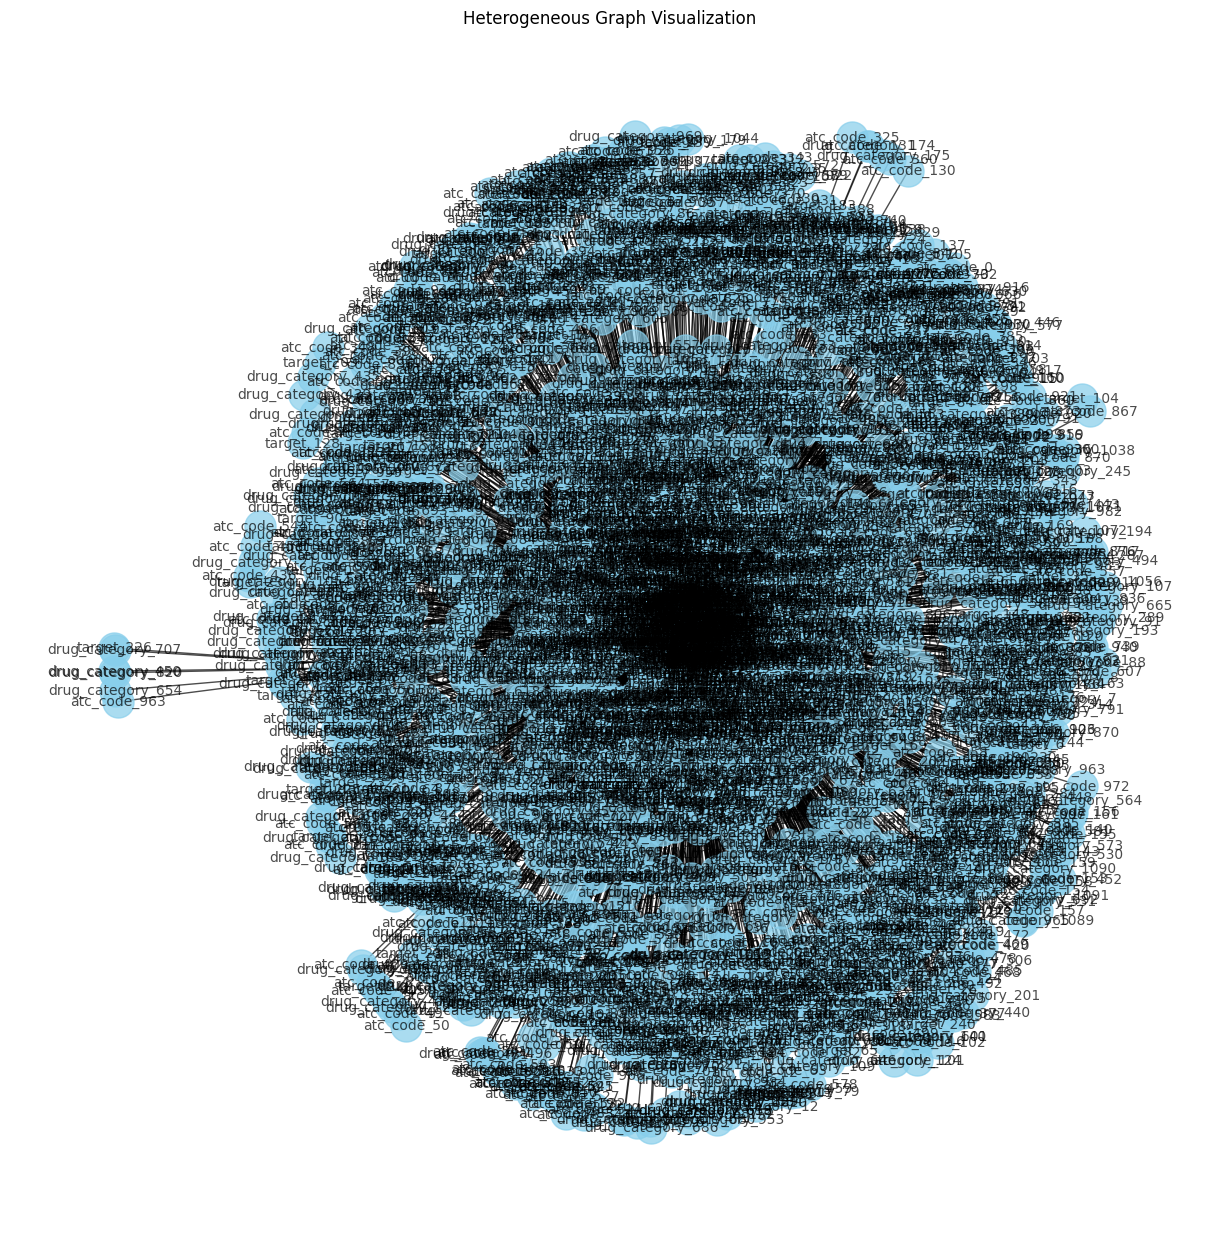

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData


G = nx.Graph()

for node_type in data_small.node_types:
    for node_idx in range(data_small[node_type].num_nodes):
        G.add_node(f'{node_type}_{node_idx}', label=node_type)

for edge_type in data_small.edge_types:
    edge_index = data_small[edge_type].edge_index
    for i in range(edge_index.shape[1]):
        source = edge_index[0, i].item()
        target = edge_index[1, i].item()
        source_label = f'{edge_type[0]}_{source}'
        target_label = f'{edge_type[2]}_{target}'
        G.add_edge(source_label, target_label, label=edge_type[1])


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Use a layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, edge_color='black', node_color='skyblue', alpha=0.7)
plt.title("Heterogeneous Graph Visualization")
plt.show()


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.explain import GNNExplainer
import pandas as pd
from torch_geometric.data import HeteroData

# Assume data_small is your HeteroData object as defined earlier

class HeteroGNN1(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGNN1, self).__init__()
        self.conv1 = HeteroConv({
            ('drug', 'isInCategory', 'drug_category'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isClassifiedAs', 'atc_code'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'targets', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'isDoping', 'doping'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interactsWith', 'drug'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['drug'])

# Initialize the model
model1 = HeteroGNN1(hidden_channels=64, out_channels=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Function to train the model
def train():
    model1.train()
    optimizer.zero_grad()
    out = model1(data_small.x_dict, data_small.edge_index_dict)
    loss = criterion(out[data_small['drug'].train_mask], data_small['drug'].y[data_small['drug'].train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Function to test the model
def test(mask):
    model1.eval()
    with torch.no_grad():
        out = model1(data_small.x_dict, data_small.edge_index_dict)
        pred = out.argmax(dim=1)
        correct = pred[mask] == data_small['drug'].y[mask]
        if int(mask.sum()) == 0:  # Check to avoid division by zero
            return float('nan')
        return int(correct.sum()) / int(mask.sum())

# Train the model
for epoch in range(1, 101):
    loss = train()
    train_acc = test(data_small['drug'].train_mask)
    val_acc = test(data_small['drug'].val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

test_acc = test(data_small['drug'].test_mask)
print(f'Test Acc: {test_acc:.4f}')

# Initialize GNNExplainer
explainer = GNNExplainer(epochs=200, lr=0.01)

# Explain a prediction for a specific node
node_idx = 0  # Index of the node you want to explain
explanation = explainer(model1, x=data_small.x_dict, edge_index=data_small.edge_index_dict, target=data_small['drug'].y, index=node_idx)

# Visualize the explanation
fig, ax = explainer.visualize_subgraph(node_idx, data_small.edge_index_dict, explanation.edge_mask, y=data_small['drug'].y)
plt.show()


Epoch: 001, Loss: 1.3158, Train Acc: 0.5000, Val Acc: 0.3450
Epoch: 002, Loss: 5.8444, Train Acc: 0.5750, Val Acc: 0.6500
Epoch: 003, Loss: 1.6676, Train Acc: 0.5750, Val Acc: 0.5850
Epoch: 004, Loss: 0.9991, Train Acc: 0.5250, Val Acc: 0.3650
Epoch: 005, Loss: 1.8962, Train Acc: 0.6250, Val Acc: 0.5550
Epoch: 006, Loss: 0.7693, Train Acc: 0.5000, Val Acc: 0.6450
Epoch: 007, Loss: 1.3985, Train Acc: 0.6000, Val Acc: 0.4600
Epoch: 008, Loss: 0.7089, Train Acc: 0.6250, Val Acc: 0.3950
Epoch: 009, Loss: 0.9246, Train Acc: 0.7000, Val Acc: 0.5550
Epoch: 010, Loss: 0.5670, Train Acc: 0.5500, Val Acc: 0.6600
Epoch: 011, Loss: 0.7873, Train Acc: 0.8000, Val Acc: 0.5750
Epoch: 012, Loss: 0.5187, Train Acc: 0.6250, Val Acc: 0.3950
Epoch: 013, Loss: 0.6738, Train Acc: 0.7000, Val Acc: 0.4400
Epoch: 014, Loss: 0.5423, Train Acc: 0.6250, Val Acc: 0.6750
Epoch: 015, Loss: 0.5562, Train Acc: 0.6000, Val Acc: 0.6700
Epoch: 016, Loss: 0.5682, Train Acc: 0.7750, Val Acc: 0.4800
Epoch: 017, Loss: 0.4718

ValueError: Heterogeneous graphs not yet supported in 'GNNExplainer'

In [16]:
import pandas as pd
import torch
import dgl

# Load encoded data from CSV files
encoded_drugbank_id_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_drugbank_id.csv')
encoded_name_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_name.csv')
encoded_state_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_state.csv')
encoded_groups_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_groups.csv')
encoded_categories_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_categories.csv')
encoded_atc_codes_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_atc_codes.csv')
encoded_targets_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_targets.csv')
encoded_interactions_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_interactions.csv')
encoded_molecular_formula_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_molecular_formula.csv')
encoded_doping_df = pd.read_csv('Heterogeneous KG/encoders_small/encoded_doping.csv')

# Convert DataFrames to tensors
encoded_drugbank_id_tensor_1 = torch.tensor(encoded_drugbank_id_df.values, dtype=torch.float32)
encoded_name_tensor_1 = torch.tensor(encoded_name_df.values, dtype=torch.float32)
encoded_state_tensor_1 = torch.tensor(encoded_state_df.values, dtype=torch.float32)
encoded_groups_tensor_1 = torch.tensor(encoded_groups_df.values, dtype=torch.float32)
encoded_categories_tensor_1 = torch.tensor(encoded_categories_df.values, dtype=torch.float32)
encoded_atc_codes_tensor_1 = torch.tensor(encoded_atc_codes_df.values, dtype=torch.float32)
encoded_targets_tensor_1 = torch.tensor(encoded_targets_df.values, dtype=torch.float32)
encoded_interactions_tensor_1 = torch.tensor(encoded_interactions_df.values, dtype=torch.float32)
encoded_molecular_formula_tensor_1 = torch.tensor(encoded_molecular_formula_df.values, dtype=torch.float32)
encoded_doping_tensor_1 = torch.tensor(encoded_doping_df.values, dtype=torch.float32)

# Define edge lists
def create_edge_list(df):
    source_nodes = []
    target_nodes = []
    for drug_idx, row in df.iterrows():
        for idx in range(len(row)):
            if row[idx] == 1:
                source_nodes.append(drug_idx)
                target_nodes.append(idx)
    return source_nodes, target_nodes

# Special handling for doping edges
doping_edges = ([], [])
unique_doping_values = list(encoded_doping_df['Doping'].unique())
doping_node_mapping = {v: i for i, v in enumerate(unique_doping_values)}

for drug_idx, doping in enumerate(encoded_doping_df['Doping']):
    doping_edges[0].append(drug_idx)
    doping_edges[1].append(doping_node_mapping[doping])

# Create a DGL heterograph
graph_data = {
    ('drug', 'isInCategory', 'drug_category'): create_edge_list(encoded_categories_df),
    ('drug', 'isClassifiedAs', 'atc_code'): create_edge_list(encoded_atc_codes_df),
    ('drug', 'targets', 'target'): create_edge_list(encoded_targets_df),
    ('drug', 'isDoping', 'doping'): (torch.tensor(doping_edges[0]), torch.tensor(doping_edges[1])),
    ('drug', 'interactsWith', 'drug'): create_edge_list(encoded_interactions_df)
}

dgl_graph = dgl.heterograph(graph_data)

# Add node features only for 'drug' nodes
dgl_graph.nodes['drug'].data['feat'] = torch.cat([
    encoded_drugbank_id_tensor_1,
    encoded_name_tensor_1,
    encoded_state_tensor_1,
    encoded_groups_tensor_1,
    encoded_molecular_formula_tensor_1
], dim=1)

print(dgl_graph)


Graph(num_nodes={'atc_code': 974, 'doping': 2, 'drug': 338, 'drug_category': 1095, 'target': 249},
      num_edges={('drug', 'interactsWith', 'drug'): 41415, ('drug', 'isClassifiedAs', 'atc_code'): 2229, ('drug', 'isDoping', 'doping'): 338, ('drug', 'isInCategory', 'drug_category'): 8347, ('drug', 'targets', 'target'): 338},
      metagraph=[('drug', 'drug', 'interactsWith'), ('drug', 'atc_code', 'isClassifiedAs'), ('drug', 'doping', 'isDoping'), ('drug', 'drug_category', 'isInCategory'), ('drug', 'target', 'targets')])
